# Identifying Fraud from Enron Email


## Project Background 

Enron was one of the largest corporates in the United States. However, It went into bankruptcy due to widespread corporate fraud. In the subsequent investigation, significant amount of confidential information was published publicly. This includes emails and detailed financial data from top executives.

For this project, we are going to make use of the Enron public data to create a machine learning model to classify whether a person in the Enron dataset is a person of interest (POI) for the Enron corporate fraud case. For more information of the Enron scandal, read here: https://en.wikipedia.org/wiki/Enron_scandal

## Data Preparation

In [3]:
import pickle
import sys
import numpy
import pandas
import sklearn
from time import time
from copy import copy

import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sys.path.append("../tools/")

from tester import test_classifier, dump_classifier_and_data
from feature_format import featureFormat, targetFeatureSplit

import enron 
import evaluate

numpy.random.seed(43)

## Create features list

In [4]:
## Initiate features list
features_list = ['poi', 'to_messages', 'salary',  'total_payments', 'total_stock_value',
                 'deferral_payments', 'bonus', 'loan_advances', 'expenses', 'shared_receipt_with_poi',
                 'restricted_stock_deferred', 'deferred_income', 'exercised_stock_options',
                 'from_this_person_to_poi', 'from_poi_to_this_person', 'restricted_stock',   
                 'other', 'long_term_incentive', 'from_messages', 'director_fees'] 

## Get POI file
fpoi = open("poi_names.txt", "r")

### Get the dataset
enron_data = pickle.load(open("final_project_dataset.pkl", "r") )

# Test print information of one recpr`d
print enron_data["SKILLING JEFFREY K"]

{'salary': 1111258, 'to_messages': 3627, 'deferral_payments': 'NaN', 'total_payments': 8682716, 'exercised_stock_options': 19250000, 'bonus': 5600000, 'restricted_stock': 6843672, 'shared_receipt_with_poi': 2042, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 26093672, 'expenses': 29336, 'loan_advances': 'NaN', 'from_messages': 108, 'other': 22122, 'from_this_person_to_poi': 30, 'poi': True, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 1920000, 'email_address': 'jeff.skilling@enron.com', 'from_poi_to_this_person': 88}


## Number of Individuals in the dataset

In [5]:
individuals = len(enron_data)
print "Number of individuals in the dataset: " + str(individuals) + " individuals"

Number of individuals in the dataset: 146 individuals


## Number of Features in the dataset

In [6]:
features_length = len(enron_data['SKILLING JEFFREY K'])
print "There are " + str(features_length) + " features in the dataset."

There are 21 features in the dataset.


## Number of POI's in the Dataset

In [7]:
def count_poi(file):
    count = 0 
    for person in file:
        if file[person]['poi'] == True:
            count += 1
    print "There are " + str(count) + " poi's in the dataset."

count_poi(enron_data)

There are 18 poi's in the dataset.


## Number of POI's

In [8]:
poi_file = open("poi_names.txt", "r")
rfile =poi_file.readlines()
poi_length = len(rfile[2:])
print "Number of POI's: " + str(poi_length) + " POI's"

Number of POI's: 35 POI's


## Detecting and Removing Outliers

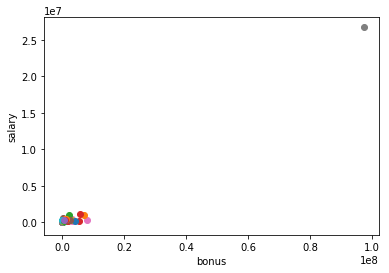

In [9]:
features = ["bonus", "salary"]
data = featureFormat(enron_data, features)

for point in data:
    bonus = point[0]
    salary = point[1]
    matplotlib.pyplot.scatter( bonus, salary )

matplotlib.pyplot.xlabel("bonus")
matplotlib.pyplot.ylabel("salary")
matplotlib.pyplot.show()

From the chart above, we can see that there is an obvious outlier at the top right corner. Could this be an employee with very huge salary and bonus? We will explore it below.

In [10]:
from pprint import pprint
outliers_in_bonus = []
for key in enron_data:
    val = enron_data[key]['bonus']
    if val == 'NaN':
        continue
    outliers_in_bonus.append((key,int(val)))

pprint(sorted(outliers_in_bonus,key=lambda x:x[1],reverse=True)[:10])

[('TOTAL', 97343619),
 ('LAVORATO JOHN J', 8000000),
 ('LAY KENNETH L', 7000000),
 ('SKILLING JEFFREY K', 5600000),
 ('BELDEN TIMOTHY N', 5249999),
 ('ALLEN PHILLIP K', 4175000),
 ('KITCHEN LOUISE', 3100000),
 ('WHALLEY LAWRENCE G', 3000000),
 ('DELAINEY DAVID W', 3000000),
 ('MCMAHON JEFFREY', 2600000)]


We can see that the biggest outlier for "Bonus" feature is the total aggregation that often appears in a spreadsheet.

In [11]:
outliers_in_salary = []
for key in enron_data:
    val = enron_data[key]['salary']
    if val == 'NaN':
        continue
    outliers_in_salary.append((key,int(val)))

pprint(sorted(outliers_in_salary,key=lambda x:x[1],reverse=True)[:10])

[('TOTAL', 26704229),
 ('SKILLING JEFFREY K', 1111258),
 ('LAY KENNETH L', 1072321),
 ('FREVERT MARK A', 1060932),
 ('PICKERING MARK R', 655037),
 ('WHALLEY LAWRENCE G', 510364),
 ('DERRICK JR. JAMES V', 492375),
 ('FASTOW ANDREW S', 440698),
 ('SHERRIFF JOHN R', 428780),
 ('RICE KENNETH D', 420636)]


In [12]:
##One tricky record that is not an Enron employee
print "One tricky record that is not an Enron employee:"
for key in enron_data:
    if "TRAVEL AGENCY" in key:
        print key

One tricky record that is not an Enron employee:
THE TRAVEL AGENCY IN THE PARK


As shown above, the major outlier is **TOTAL**. This is the total aggregation of all the records and thus, should be removed from the dataset.

The other record **THE TRAVEL AGENCY IN THE PARK** is also an outlier as it is not an Enron employee. This record should be removed as well.

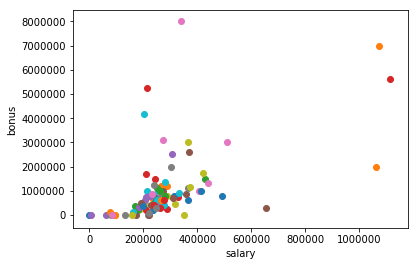

In [13]:
features = ["salary", "bonus"]

##Remove the outliers mentioned above
enron_data.pop('TOTAL',0)
enron_data.pop('THE TRAVEL AGENCY IN THE PARK',0)

my_dataset = copy(enron_data)
my_feature_list = copy(features_list)

data = featureFormat(enron_data, features)

##Plot the cleaned data
for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

We also need to check two more important features for outliers. These two features are "from_poi_to_this_person" and "from_this_person_to_poi".

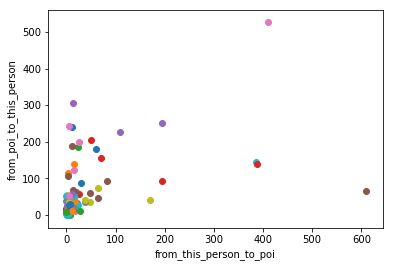

In [14]:
features = ["from_this_person_to_poi", "from_poi_to_this_person"]
data = featureFormat(enron_data, features)


### plot the two features
for point in data:
    from_this_person_to_poi = point[0]
    from_poi_to_this_person = point[1]
    matplotlib.pyplot.scatter( from_this_person_to_poi, from_poi_to_this_person )

matplotlib.pyplot.xlabel("from_this_person_to_poi")
matplotlib.pyplot.ylabel("from_poi_to_this_person")
matplotlib.pyplot.show()

Based on the chart above, there are a few outliers that should be further investigated.

In [15]:
to_poi_outliers = []
for key in enron_data:
    val = enron_data[key]['from_this_person_to_poi']
    if val == 'NaN':
        continue
    to_poi_outliers.append((key,int(val)))

pprint(sorted(to_poi_outliers,key=lambda x:x[1],reverse=True)[:10])

[('DELAINEY DAVID W', 609),
 ('LAVORATO JOHN J', 411),
 ('KEAN STEVEN J', 387),
 ('BECK SALLY W', 386),
 ('KITCHEN LOUISE', 194),
 ('MCCONNELL MICHAEL S', 194),
 ('KAMINSKI WINCENTY J', 171),
 ('BELDEN TIMOTHY N', 108),
 ('SHANKMAN JEFFREY A', 83),
 ('BUY RICHARD B', 71)]


In [16]:
from_poi_outliers = []
for key in enron_data:
    val = enron_data[key]['from_poi_to_this_person']
    if val == 'NaN':
        continue
    from_poi_outliers.append((key,int(val)))

pprint(sorted(from_poi_outliers,key=lambda x:x[1],reverse=True)[:10])

[('LAVORATO JOHN J', 528),
 ('DIETRICH JANET R', 305),
 ('KITCHEN LOUISE', 251),
 ('FREVERT MARK A', 242),
 ('COLWELL WESLEY', 240),
 ('BELDEN TIMOTHY N', 228),
 ('REDMOND BRIAN L', 204),
 ('CALGER CHRISTOPHER F', 199),
 ('DONAHUE JR JEFFREY M', 188),
 ('WHALLEY LAWRENCE G', 186)]


The records with the biggest values seem to be enron_employee. As such, those records need to be kept.

## Further Data Cleaning and Exploration

After removing the outliers, we are going to explore further on the dataset for any other anomalies.

In [17]:
df = pandas.DataFrame.from_records(list(enron_data.values()))
persons = pandas.Series(list(enron_data.keys()))

### List of Datatypes

In [18]:
df.dtypes

bonus                        object
deferral_payments            object
deferred_income              object
director_fees                object
email_address                object
exercised_stock_options      object
expenses                     object
from_messages                object
from_poi_to_this_person      object
from_this_person_to_poi      object
loan_advances                object
long_term_incentive          object
other                        object
poi                            bool
restricted_stock             object
restricted_stock_deferred    object
salary                       object
shared_receipt_with_poi      object
to_messages                  object
total_payments               object
total_stock_value            object
dtype: object

### Summary View of Dataset

In [19]:
print df.head()

     bonus deferral_payments deferred_income director_fees  \
0   600000               NaN             NaN           NaN   
1  1200000           1295738        -1386055           NaN   
2   350000               NaN         -400729           NaN   
3      NaN               NaN             NaN           NaN   
4  1500000               NaN        -3117011           NaN   

              email_address exercised_stock_options expenses from_messages  \
0      mark.metts@enron.com                     NaN    94299            29   
1                       NaN                 6680544    11200           NaN   
2  steven.elliott@enron.com                 4890344    78552           NaN   
3     bill.cordes@enron.com                  651850      NaN            12   
4    kevin.hannon@enron.com                 5538001    34039            32   

  from_poi_to_this_person from_this_person_to_poi        ...         \
0                      38                       1        ...          
1               

### Exploring "NaN" Values

As shown in the summary view, there are a lot of records with "NaN" values in the dataset. This may affect the predictive model. As such, we need to handle the "NaN" values.

In [20]:
### Convert "NaN" string to Numpy NaN
df.replace(to_replace='NaN', value=numpy.nan, inplace=True)

### Count total occurence of NaN values.
print "Number of records with NaN values:"
print df.isnull().sum()

### Dataset Shape
print "\nDataset shape: "
print df.shape
### print df.head()

Number of records with NaN values:
bonus                         63
deferral_payments            106
deferred_income               96
director_fees                128
email_address                 33
exercised_stock_options       43
expenses                      50
from_messages                 58
from_poi_to_this_person       58
from_this_person_to_poi       58
loan_advances                141
long_term_incentive           79
other                         53
poi                            0
restricted_stock              35
restricted_stock_deferred    127
salary                        50
shared_receipt_with_poi       58
to_messages                   58
total_payments                21
total_stock_value             19
dtype: int64

Dataset shape: 
(144, 21)


### Handling NaN Values

In [21]:
df_replace_nan = df.replace(to_replace=numpy.nan, value=0)
df_replace_nan = df.fillna(0).copy(deep=True)
df_replace_nan.columns = list(df.columns.values)

print "Number of records with NaN values:"
print df_replace_nan.isnull().sum()

print "\nOverview of df: "
print df_replace_nan.head()

df_replace_nan.describe()

Number of records with NaN values:
bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
email_address                0
exercised_stock_options      0
expenses                     0
from_messages                0
from_poi_to_this_person      0
from_this_person_to_poi      0
loan_advances                0
long_term_incentive          0
other                        0
poi                          0
restricted_stock             0
restricted_stock_deferred    0
salary                       0
shared_receipt_with_poi      0
to_messages                  0
total_payments               0
total_stock_value            0
dtype: int64

Overview of df: 
       bonus  deferral_payments  deferred_income  director_fees  \
0   600000.0                0.0              0.0            0.0   
1  1200000.0          1295738.0       -1386055.0            0.0   
2   350000.0                0.0        -400729.0            0.0   
3        0.0   

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02
mean,6.759974e+05,2.220896e+05,-1.936833e+05,9980.319444,2.075802e+06,35375.340278,363.583333,38.756944,24.625000,5.828125e+05,3.369578e+05,2.947455e+05,8.685363e+05,7.341790e+04,1.854460e+05,702.611111,1238.555556,2.256543e+06,2.909786e+06
std,1.233155e+06,7.541013e+05,6.060111e+05,31300.575144,4.795513e+06,45309.303038,1450.675239,74.276769,79.778266,6.794472e+06,6.871826e+05,1.131325e+06,2.016572e+06,1.301983e+06,1.970421e+05,1077.290736,2237.564816,8.847189e+06,6.189018e+06
min,0.000000e+00,-1.025000e+05,-3.504386e+06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,-1.787380e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,-3.708600e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.434500e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,9.019275e+04,2.443265e+05
50%,3.000000e+05,0.000000e+00,0.000000e+00,0.000000,6.082935e+05,20182.000000,17.500000,4.000000,0.000000,0.000000e+00,0.000000e+00,9.190000e+02,3.605280e+05,0.000000e+00,2.105960e+05,114.000000,347.500000,9.413595e+05,9.659550e+05
75%,8.000000e+05,8.535500e+03,0.000000e+00,0.000000,1.683580e+06,53328.250000,53.000000,41.250000,14.000000,0.000000e+00,3.745862e+05,1.485770e+05,7.374560e+05,0.000000e+00,2.696675e+05,933.750000,1623.000000,1.945668e+06,2.295176e+06
max,8.000000e+06,6.426990e+06,0.000000e+00,137864.000000,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,8.152500e+07,5.145434e+06,1.035973e+07,1.476169e+07,1.545629e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07


## Feature Selection

### Using Pairgrid to Describe Relationship between Features

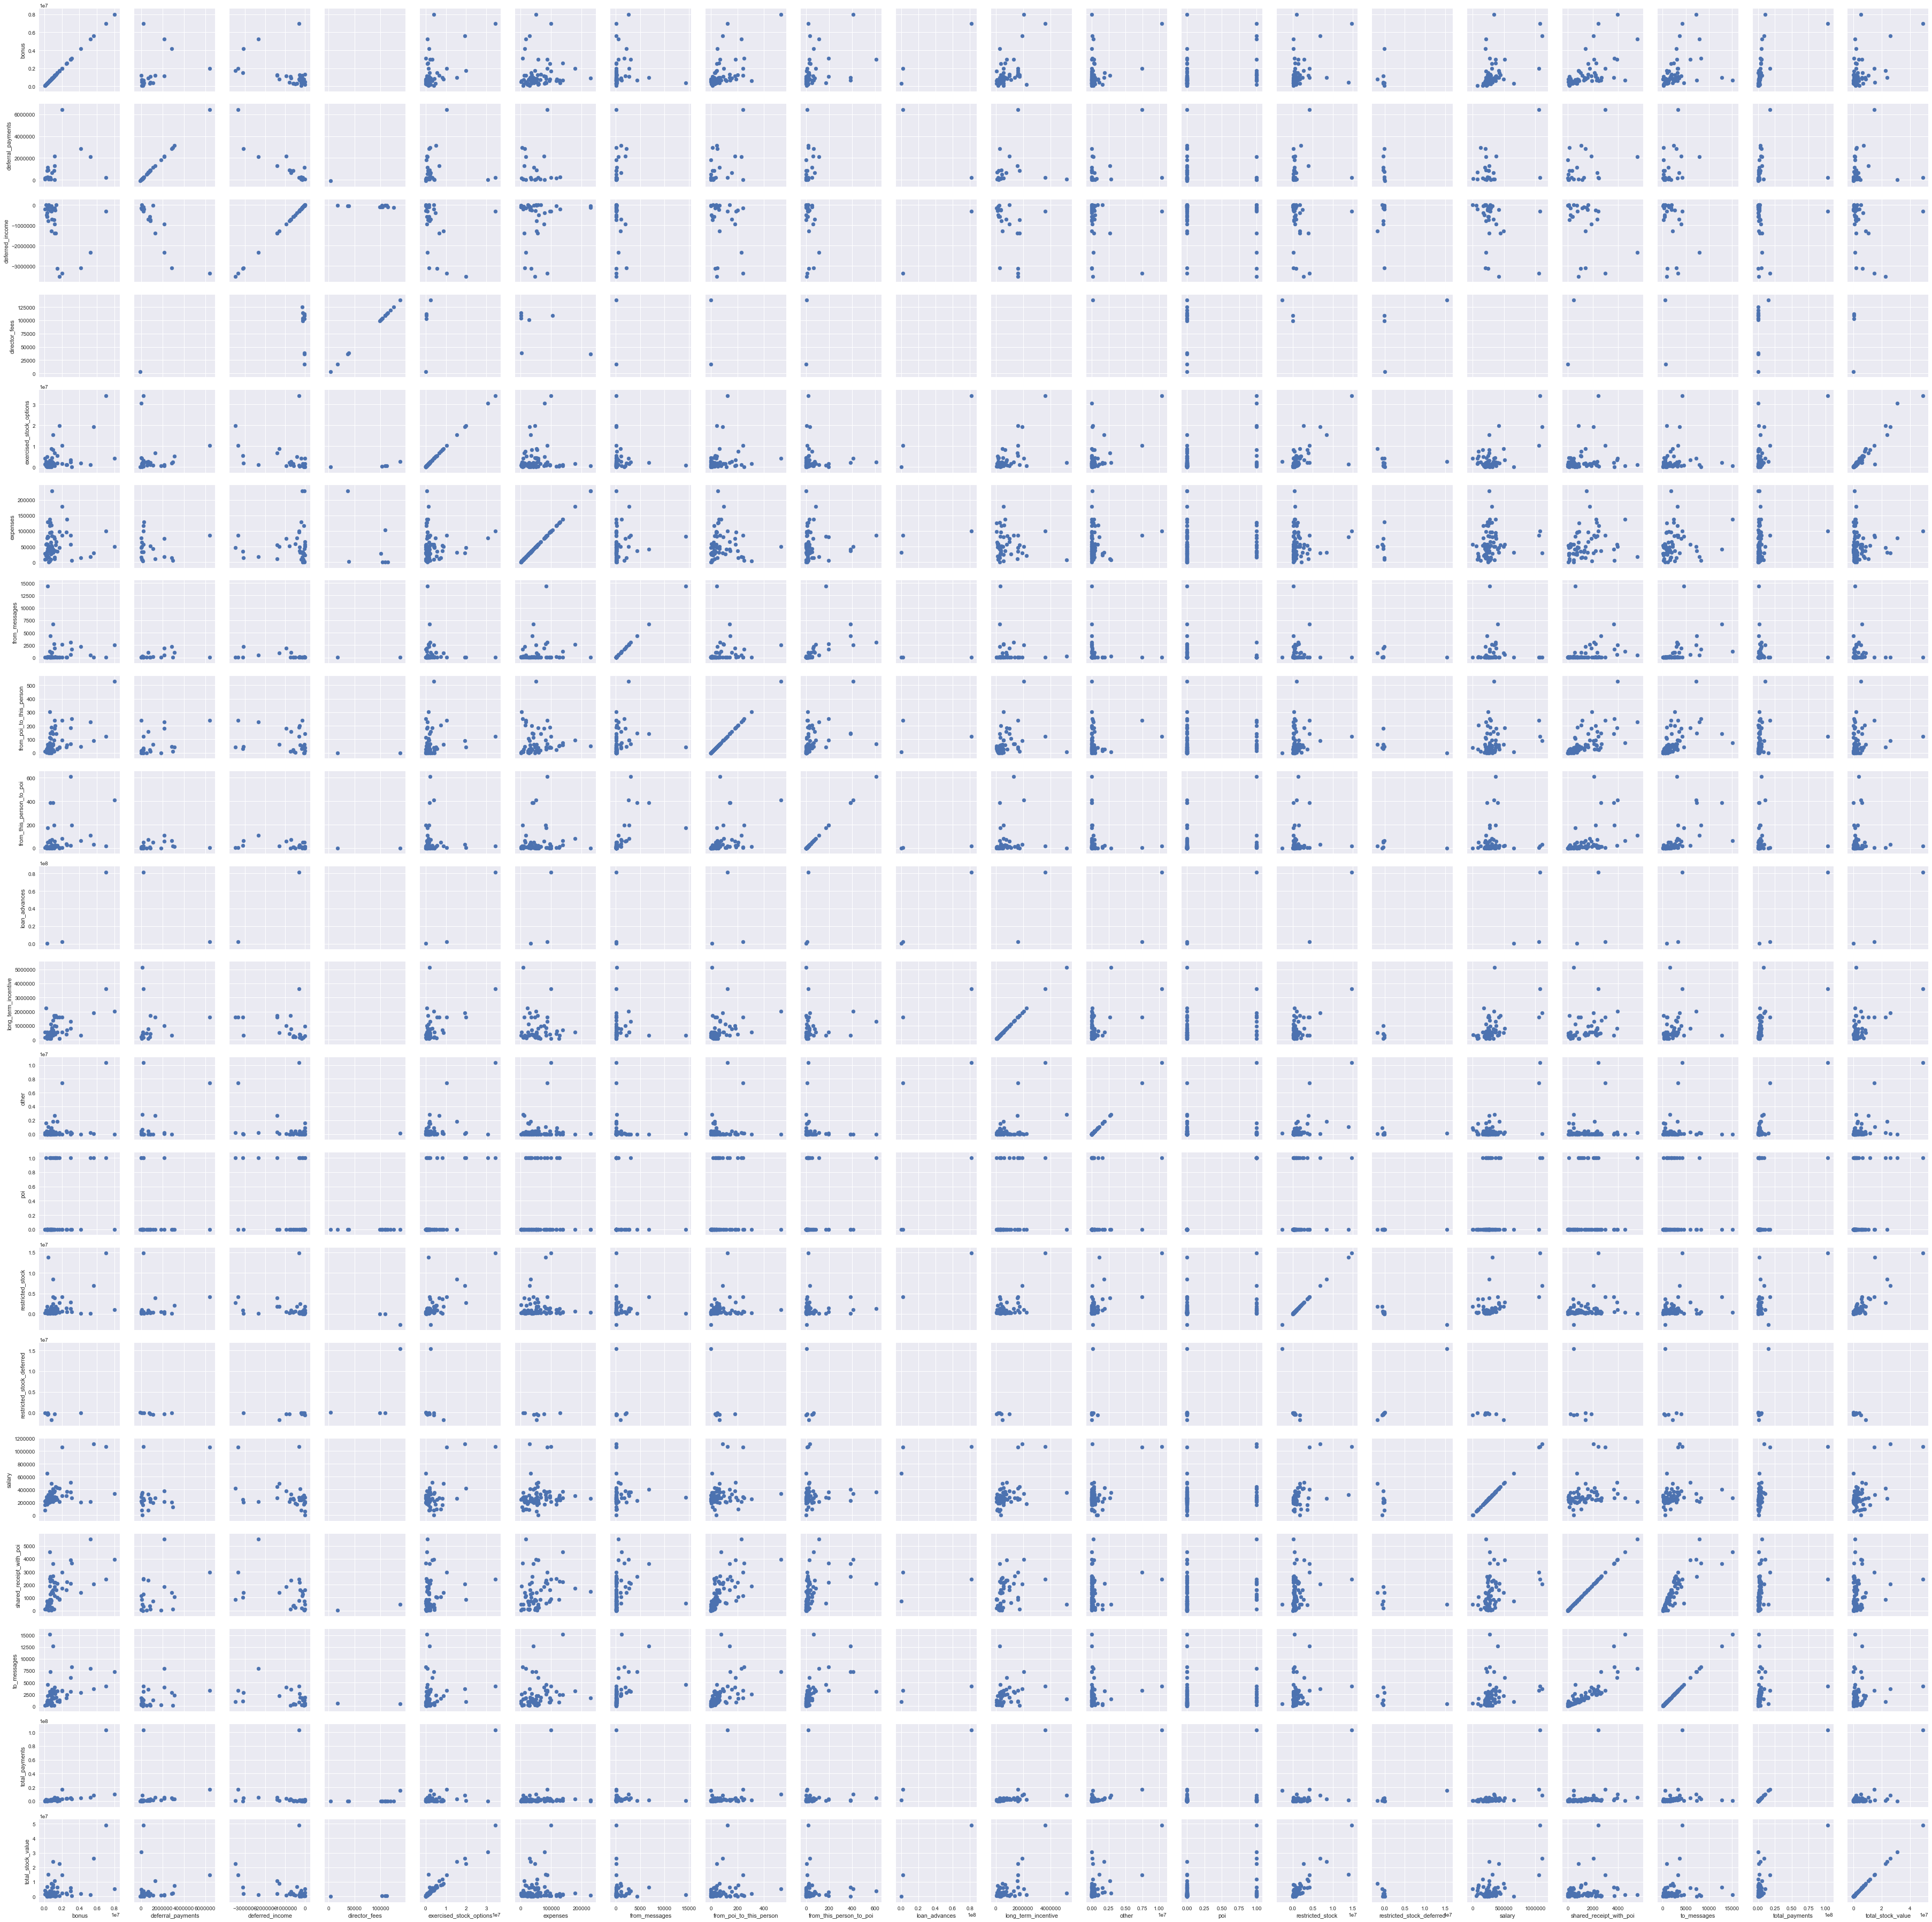

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

grid = sns.PairGrid(df)
grid.map(plt.scatter);

There is no obvious trend or relationship that can be observed from the pair grid above. We will move on to the other methods.

### Using Heatmap to Explore Features

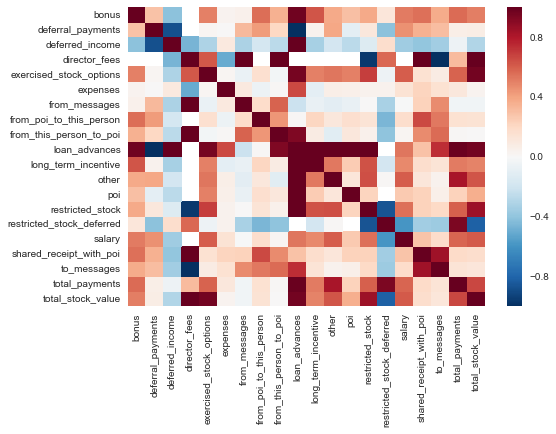

In [41]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.3, cbar_kws={"shrink": .5}, ax=ax)

Not much pattern can be seen from the chart above as well.

### Using Correlation Table and Correlation Plot to Explore Features

In [42]:
print df.head()

       bonus  deferral_payments  deferred_income  director_fees  \
0   600000.0                NaN              NaN            NaN   
1  1200000.0          1295738.0       -1386055.0            NaN   
2   350000.0                NaN        -400729.0            NaN   
3        NaN                NaN              NaN            NaN   
4  1500000.0                NaN       -3117011.0            NaN   

              email_address  exercised_stock_options  expenses  from_messages  \
0      mark.metts@enron.com                      NaN   94299.0           29.0   
1                       NaN                6680544.0   11200.0            NaN   
2  steven.elliott@enron.com                4890344.0   78552.0            NaN   
3     bill.cordes@enron.com                 651850.0       NaN           12.0   
4    kevin.hannon@enron.com                5538001.0   34039.0           32.0   

   from_poi_to_this_person  from_this_person_to_poi        ...          \
0                     38.0          

In [24]:
df.corr(method='pearson')

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
bonus,1.000000,0.293543,-0.411659,NaN,0.506998,0.033799,0.052725,0.562187,0.354634,0.973826,0.625259,0.376371,0.302384,0.376992,0.118222,0.523190,0.549102,0.372997,0.569054,0.509441
deferral_payments,0.293543,1.000000,-0.881500,NaN,0.019009,0.004800,0.321947,0.424101,0.206993,-1.000000,0.042448,0.385829,-0.098428,0.115088,-0.412777,0.455884,0.356696,0.310129,0.066774,0.075710
deferred_income,-0.411659,-0.881500,1.000000,-0.464837,-0.308076,0.101181,-0.319995,-0.178951,-0.271673,1.000000,-0.331715,-0.185219,-0.265698,-0.133895,0.173154,-0.353816,-0.394677,-0.350815,-0.054404,-0.298189
director_fees,NaN,NaN,-0.464837,1.000000,0.623257,-0.504631,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,-0.968483,0.575257,NaN,1.000000,-1.000000,0.317360,0.997476
exercised_stock_options,0.506998,0.019009,-0.308076,0.623257,1.000000,0.019412,-0.066129,0.160253,-0.030101,0.960259,0.500016,0.536248,0.503551,0.690935,-0.051644,0.607324,0.154333,0.079568,0.591690,0.963560
expenses,0.033799,0.004800,0.101181,-0.504631,0.019412,1.000000,0.094144,-0.059244,0.014964,0.658681,-0.100766,0.062874,0.060292,0.042896,0.040947,0.145364,0.223495,0.155070,0.109798,0.034707
from_messages,0.052725,0.321947,-0.319995,1.000000,-0.066129,0.094144,1.000000,0.186708,0.588687,-0.213768,-0.071958,-0.101686,-0.074308,0.003145,-0.326671,-0.003541,0.230855,0.475450,-0.033089,-0.036310
from_poi_to_this_person,0.562187,0.424101,-0.178951,NaN,0.160253,-0.059244,0.186708,1.000000,0.445063,0.009878,0.212538,0.111249,0.167722,0.133594,-0.455876,0.179055,0.659264,0.525667,0.154431,0.146366
from_this_person_to_poi,0.354634,0.206993,-0.271673,1.000000,-0.030101,0.014964,0.588687,0.445063,1.000000,0.934835,0.083591,-0.110335,0.112940,0.049284,-0.398550,0.021288,0.475748,0.568506,0.011556,0.001289
loan_advances,0.973826,-1.000000,1.000000,NaN,0.960259,0.658681,-0.213768,0.009878,0.934835,1.000000,1.000000,1.000000,0.999851,1.000000,NaN,0.535252,0.291501,0.739805,0.991879,0.962026


In [43]:
pearson = df.corr(method='pearson')

# Assuming target feature is the last, then remove correlation with itself
print peasr
corr_with_target = pearson.ix[-7][:-1]
print corr_with_target
print "\nCorrelations with target attribute: "
print corr_with_target

# Correlations with absolute value:
print "\nCorrelations with absolute value: "
print corr_with_target[abs(corr_with_target).argsort()[::-1]]

bonus                        0.376992
deferral_payments            0.115088
deferred_income             -0.133895
director_fees               -0.968483
exercised_stock_options      0.690935
expenses                     0.042896
from_messages                0.003145
from_poi_to_this_person      0.133594
from_this_person_to_poi      0.049284
loan_advances                1.000000
long_term_incentive          0.635172
other                        0.644357
poi                          0.224814
restricted_stock             1.000000
restricted_stock_deferred   -0.867102
salary                       0.550824
shared_receipt_with_poi      0.232660
to_messages                  0.195570
total_payments               0.595728
total_stock_value            0.855250
Name: restricted_stock, dtype: float64
bonus                        0.376992
deferral_payments            0.115088
deferred_income             -0.133895
director_fees               -0.968483
exercised_stock_options      0.690935
expenses   

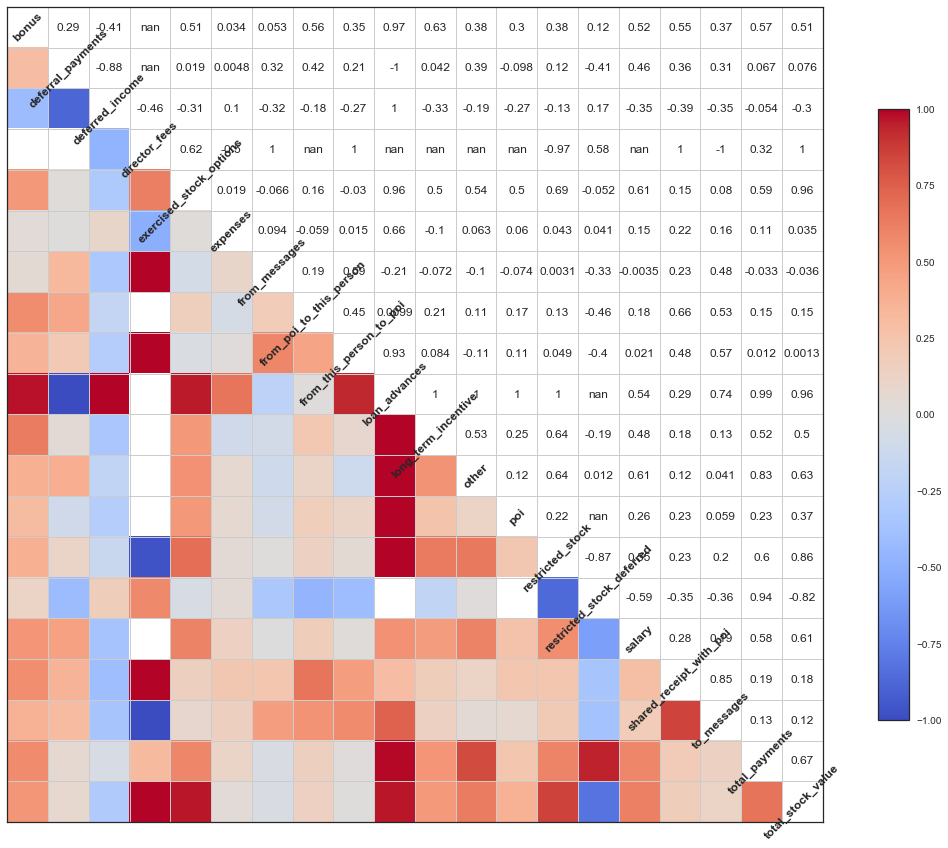

In [26]:
import seaborn
from seaborn.linearmodels import corrplot,symmatplot

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))
seaborn.linearmodels.corrplot(df, ) # compute and plot the pair-wise correlations
# save to file, remove the big white borders
plt.savefig('attribute_correlations.png', tight_layout=True)

I can see some of the features more important than others, but to be on the safe side I am going to use the already provided scikit-learns SelectKBest method to get 10 best features.

### Use scikit-learn's SelectKBest feature selection:

In [36]:
def get_k_best(enron_data, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(enron_data, features_list)
    labels, features = targetFeatureSplit(data)
    
    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print "{0} best features: {1}\n".format(k, k_best_features.keys())
    return k_best_features
    

In [37]:
# get K-best features
target_label = 'poi'
from sklearn.feature_selection import SelectKBest
# print enron_data
num_features = 10 # 10 best features
best_features = get_k_best(enron_data, features_list, num_features)
# print best_features
my_feature_list = [target_label] + best_features.keys()
# print my_feature_list

# print "{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:])

10 best features: ['salary', 'total_payments', 'loan_advances', 'bonus', 'total_stock_value', 'shared_receipt_with_poi', 'exercised_stock_options', 'deferred_income', 'restricted_stock', 'long_term_incentive']



Since we found our best features courtsey of SelecKBest, Next task is to see if I need to engineer some new features that will help me with my analysis.

## Feature Engineering:

In [29]:
import warnings
warnings.filterwarnings('ignore')

#Engineerd Features are:
eng_feat1='poi_ratio'
eng_feat2='fraction_to_poi'
eng_feat3='fraction_from_poi'


# add'em
enron.add_poi_ratio(enron_data, my_feature_list)
enron.add_fraction_to_poi(enron_data, my_feature_list)
enron.add_fraction_from_poi(enron_data, my_feature_list)


eng_feature_list=my_feature_list 
print my_feature_list
print eng_feature_list


['poi', 'salary', 'total_payments', 'loan_advances', 'bonus', 'total_stock_value', 'shared_receipt_with_poi', 'exercised_stock_options', 'deferred_income', 'restricted_stock', 'long_term_incentive', 'poi_ratio', 'fraction_to_poi', 'fraction_from_poi']
['poi', 'salary', 'total_payments', 'loan_advances', 'bonus', 'total_stock_value', 'shared_receipt_with_poi', 'exercised_stock_options', 'deferred_income', 'restricted_stock', 'long_term_incentive', 'poi_ratio', 'fraction_to_poi', 'fraction_from_poi']


##Feature Scaling:

In [30]:
# extract the features specified in features_list
data = featureFormat(enron_data, eng_feature_list)

labels, features = targetFeatureSplit(data)

# scale features via min-max
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)



##splitting data into training and test:

We are going to use 30% of the data as test and validation.  70% is going to be used as training.

In [31]:
features_train,features_test,labels_train,labels_test = sklearn.cross_validation.train_test_split(features,labels, test_size=0.3, random_state=42)


print labels
print features

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
[[ 0.32916568  0.01025327  0.         ...,  0.20793561  0.03448276
   0.2166548 ]
 [ 0.24036002  0.05440667  0.         ...,  0.          0.          0.        ]
 [ 0.15382656  0.00204447  0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.23866105  0.01055103  0.      

##Looking at different models

Let us iterarte through list to pick the best models.

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Extra Trees"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    ExtraTreesClassifier()]


 # iterate over classifiers
for name, clf in zip(names, classifiers):
        clf.fit(features_train,labels_train)
        scores = clf.score(features_test,labels_test)
        print " "
        print "Classifier:"
        evaluate.evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print "====================================================================="

 
Classifier:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
precision: 0.141072222222
recall:    0.0641056277056
Accuracy: 0.84 (+/- 0.00)
 
Classifier:
SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
precision: 0.0
recall:    0.0
Accuracy: 0.84 (+/- 0.00)
 
Classifier:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
precision: 0.00166666666667
recall:    0.000916666666667
Accuracy: 0.84 (+/- 0.00)
 
Classifier:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nod

The model I am picking DecisionTreeClassifier.
Let us use the grid_search.GridSearchCV to tune these models

###Model tuning using grid_search.GridSearchCV

#### define cv and scoring

In [33]:
from sklearn import grid_search
from sklearn.tree import DecisionTreeClassifier

cv = sklearn.cross_validation.StratifiedShuffleSplit(labels, n_iter=10)
def scoring(estimator, features_test, labels_test):
     labels_pred = estimator.predict(features_test)
     p = sklearn.metrics.precision_score(labels_test, labels_pred, average='micro')
     r = sklearn.metrics.recall_score(labels_test, labels_pred, average='micro')
     if p > 0.3 and r > 0.3:
            return sklearn.metrics.f1_score(labels_test, labels_pred, average='macro')
     return 0


###DecisionTreeClassifier tunning

In [34]:
t0 = time()
parameters = {'max_depth': [1,2,3,4,5,6,8,9,10],'min_samples_split':[1,2,3,4,5],'min_samples_leaf':[1,2,3,4,5,6,7,8], 'criterion':('gini', 'entropy')}

dtc_clf = sklearn.tree.DecisionTreeClassifier() 
dtcclf = grid_search.GridSearchCV(dtc_clf, parameters, scoring = scoring, cv = cv)

dtcclf.fit(features, labels)
print dtcclf.best_estimator_
print dtcclf.best_score_
print 'Processing time:',round(time()-t0,3) ,'s'


ValueError: min_samples_split must be at least 2 or in (0, 1], got 1

##Classifier validation

### DecisionTreeClassifier  Validation 1 (StratifiedShuffleSplit, folds = 1000)

In [ ]:
t0 = time()
dtc_best_clf = dtcclf.best_estimator_
   
test_classifier(dtc_best_clf, enron_data, eng_feature_list)

print 'Processing time:',round(time()-t0,3) ,'s'

###DecisionTreeClassifier Validation 2 (Randomized, partitioned trials, n=1,000)

In [ ]:
t0 = time()
dtc_best_clf = dtcclf.best_estimator_
   
evaluate.evaluate_clf(dtc_best_clf, features, labels, num_iters=1000, test_size=0.3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print 'Processing time:',round(time()-t0,3) ,'s'

## Dump my classifier

In [ ]:
dump_classifier_and_data(dtc_best_clf, enron_data, eng_feature_list)